In [1]:
import numpy as np
import nengo
from nengo.dists import Choice, Uniform
from nengo.solvers import NoSolver
import matplotlib.pyplot as plt
import seaborn

In [2]:
def make_US_CS_arrays(pairings=3, dt=0.001, seed=0):  # times measured in seconds
    rng = np.random.RandomState(seed=seed)
    pt = 2  # empty time pre-tone
    tt = 3  # tone time
    ps = 4  # empty time pre-shock
    st = 1  # shock time
    wt = 5  # delay time
    at = 5  # active time
    assert at == pt+tt == ps+st, "stimulus times unaligned"
    CS_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    US_array = np.zeros((int(pairings*(wt+at)/dt))*2)
    for i in range(pairings):
        CS_array[int(i*(wt+at)/dt) : int((i*(wt+at)+pt)/dt)] = 0  # nothing
        US_array[int(i*(wt+at)/dt) : int((i*(wt+at)+ps)/dt)] = 0  # nothing
        CS_array[int((i*(wt+at)+pt)/dt) : int((i*(wt+at)+pt+tt)/dt)] = 1  # tone
        US_array[int((i*(wt+at)+ps)/dt) : int((i*(wt+at)+ps+st)/dt)] = 1  # shock
        CS_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
        US_array[int((i*(wt+at)+at)/dt) : int(i*(wt+at)+(wt+at)/dt)] = 0  # delay
    return CS_array, US_array

# Central Amygdala

In [3]:
def go(t, d_thal_CeL, tone_func, shock_func, seed=0, 
       oxy_func=lambda t: 0.5, vaso_func=lambda t: 1, musc_CeL_func=lambda t: 0, musc_CeM_func=lambda t: 0):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.01
    model.config[nengo.Probe].synapse = 0.01
    with model:
        # inputs and outputs
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        oxy_inpt = nengo.Node(oxy_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition
        vaso_inpt = nengo.Node(vaso_func)  # default excitation of CeM neurons, causing default freezing
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        musc_CeL_inpt = nengo.Node(musc_CeL_func)
        musc_CeM_inpt = nengo.Node(musc_CeM_func)
        
        # ensembles
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        CeL_in = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1]]), radius=np.sqrt(2), label='CeL_in')  # [tone, shock]
        CeL_out = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_out')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        error_CeL = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL')
        # connections
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(oxy_inpt, CeL_out)
        nengo.Connection(vaso_inpt, CeM)
        thal_CeL = nengo.Connection(thalamus, CeL_in[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(3e-6))  # learning
        nengo.Connection(spinal_cord, CeL_in[1])
        nengo.Connection(CeL_in[0], CeL_out, transform=-0.75)  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_out, CeL_in[0], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeL_in[1], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeM, transform=-1)  # inhibit default freezing
        nengo.Connection(CeL_in, error_CeL, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed later)
        nengo.Connection(error_CeL, thal_CeL.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(CeM, PAG, transform=-1)
        nengo.Connection(motor_inpt, PAG)
        # pharmacology
        nengo.Connection(musc_CeL_inpt, CeL_in.neurons, transform=np.ones((CeL_in.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, CeL_out.neurons, transform=np.ones((CeL_out.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, error_CeL.neurons, transform=np.ones((error_CeL.n_neurons, 1)))
        nengo.Connection(musc_CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        # probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_CeL_in = nengo.Probe(CeL_in)  
        p_CeL_out = nengo.Probe(CeL_out)
        p_CeM = nengo.Probe(CeM)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL = nengo.Probe(error_CeL)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, seed=seed)
    with sim:
        sim.run(t)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        CeL_in = sim.data[p_CeL_in],
        CeL_out = sim.data[p_CeL_out],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL = sim.data[p_error_CeL],
        thal_CeL = sim.data[p_thal_CeL][-1].T,  
    )

### Activation of CeM with optogenetics (vasopressin) induced spontaneous freezing

/home/pduggins/.local/share/virtualenvs/amygdala-AwzrIum2/lib/python3.7/site-packages/nengo/utils/numpy.py:79: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  v = a[inds]


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

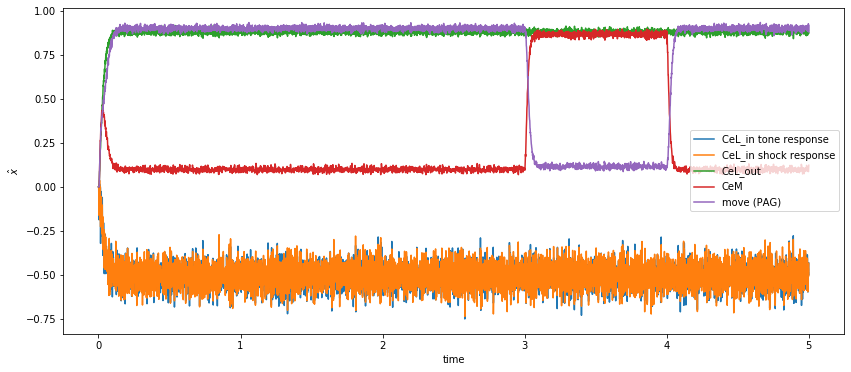

In [4]:
t = 5
dt = 0.001
tone_func = lambda t: 0
shock_func = lambda t: 0
vaso_func = lambda t: 1.75 if 3<t<4 else 1

data = go(t, np.zeros((200, 1)), tone_func, shock_func, vaso_func=vaso_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inactivation of CeM (muscimol) does not induce freezing

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

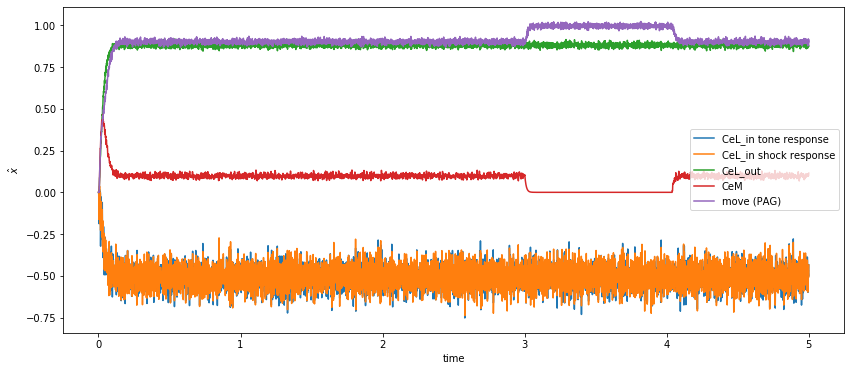

In [5]:
t = 5
dt = 0.001
tone_func = lambda t: 0
shock_func = lambda t: 0
musc_CeM_func = lambda t: -1 if 3<t<4 else 0

data = go(t, np.zeros((200, 1)), tone_func, shock_func, musc_CeM_func=musc_CeM_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inactivation of CeL (muscimol) induces spontaneous freezing

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

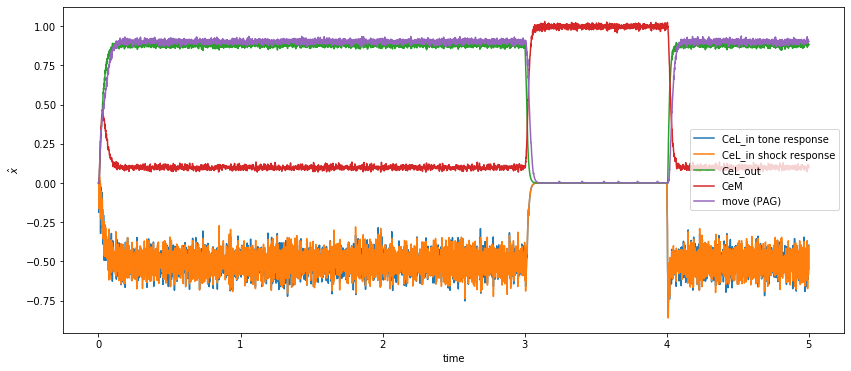

In [6]:
t = 5
dt = 0.001
tone_func = lambda t: 0
shock_func = lambda t: 0
musc_CeL_func = lambda t: -1 if 3<t<4 else 0

data = go(t, np.zeros((200, 1)), tone_func, shock_func, musc_CeL_func=musc_CeL_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

###  normal fear conditioning (control)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

/home/pduggins/.local/share/virtualenvs/amygdala-AwzrIum2/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


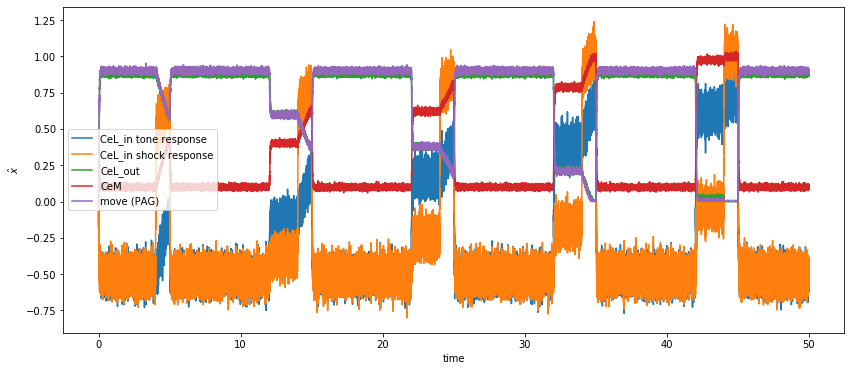

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

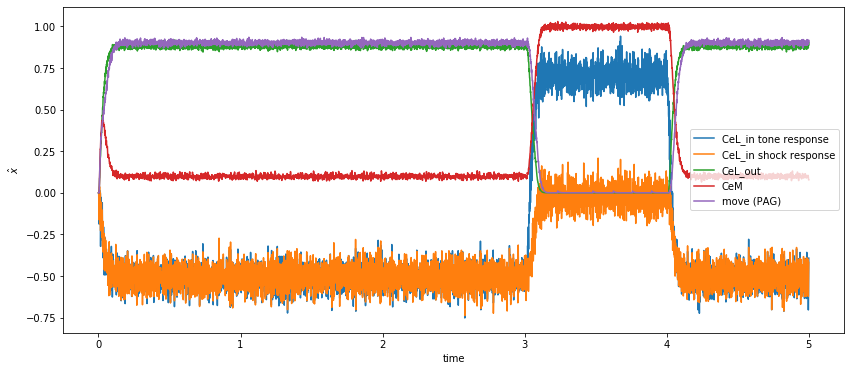

In [7]:
t = 50
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]

data = go(t, np.zeros((200, 1)), tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Inactivation of CeL (muscimol) during training prevents learning

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

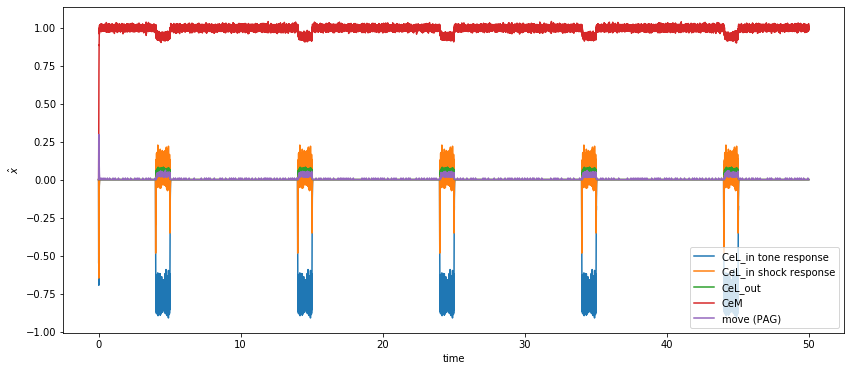

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

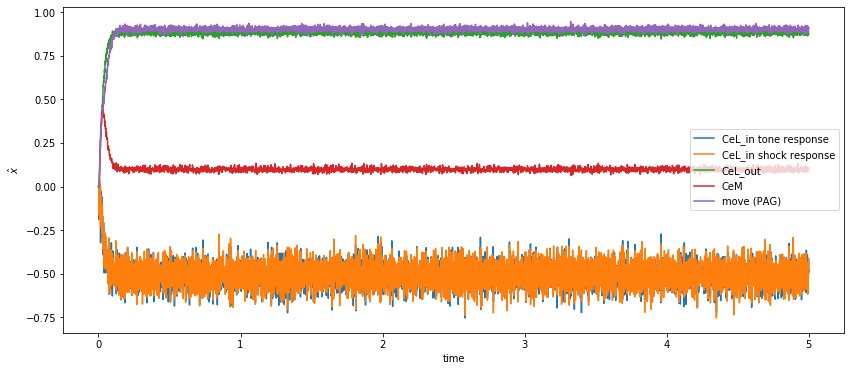

In [8]:
t = 50
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
musc_CeL_func = lambda t: -1

data = go(t, np.zeros((200, 1)), tone_func, shock_func, musc_CeL_func=musc_CeL_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

### Oxytocin applied during training does not affect conditioning

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

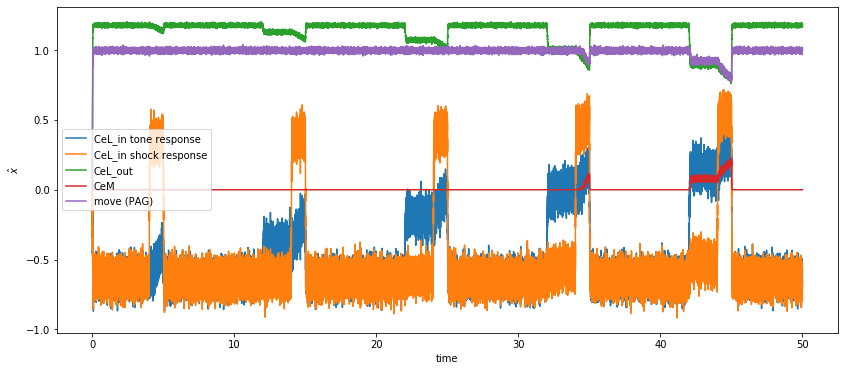

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

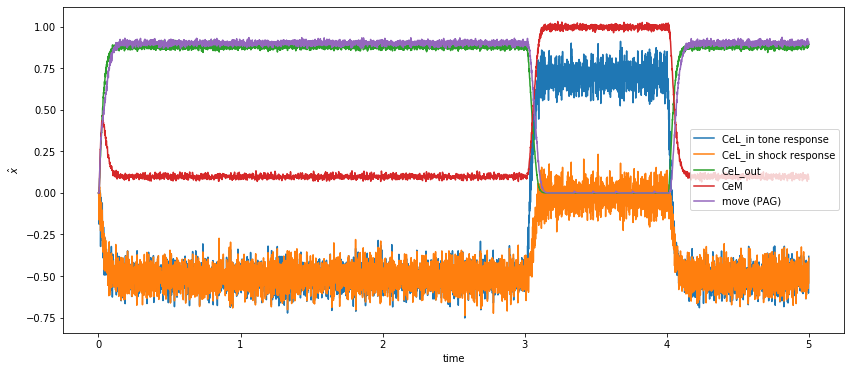

In [9]:
t = 50
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
oxy_func = lambda t: 1

data = go(t, np.zeros((200, 1)), tone_func, shock_func, oxy_func=oxy_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

## Oxytocin applied during testing partially reduces fear response

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

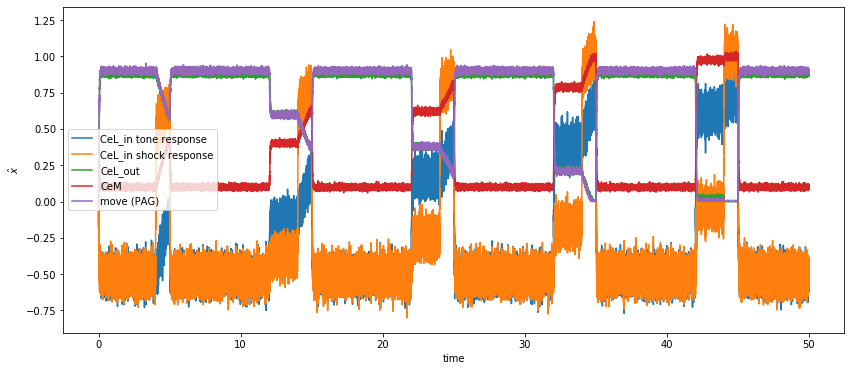

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

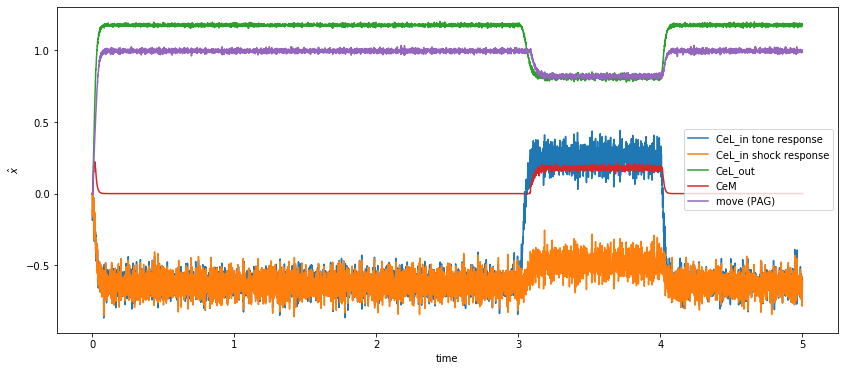

In [10]:
t = 50
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]

data = go(t, np.zeros((200, 1)), tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0
oxy_func = lambda t: 1

data = go(t, d_thal_CeL, tone_func, shock_func, oxy_func=oxy_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['CeL_in'][:,0], label='CeL_in tone response')
ax.plot(data['times'], data['CeL_in'][:,1], label='CeL_in shock response')
ax.plot(data['times'], data['CeL_out'], label='CeL_out')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

# Lateral and Central Amygdala

In [51]:
def go(t, d_thal_CeL, d_cortex_LA, d_LA_CeL, tone_func, shock_func, seed=0, 
       oxy_func=lambda t: 0.5, vaso_func=lambda t: 1, musc_CeL_func=lambda t: 0, musc_CeM_func=lambda t: 0, BLA_GABA_func=lambda t: 0.5):
    
    model = nengo.Network(seed=seed)
    model.config[nengo.Connection].synapse = 0.02
    model.config[nengo.Probe].synapse = 0.02
    with model:
        # Nodes
        tone_inpt = nengo.Node(tone_func)  # CS input
        shock_inpt = nengo.Node(shock_func)  # US input
        oxy_inpt = nengo.Node(oxy_func)  # default excitation of CeL neurons that inhibit CeM, maintaining movement via disinhibition
        vaso_inpt = nengo.Node(vaso_func)  # default excitation of CeM neurons, causing default freezing
        motor_inpt = nengo.Node(1)  # default excitation of PAG neurons, causing movement
        BLA_GABA_inpt = nengo.Node(BLA_GABA_func)
        musc_CeL_inpt = nengo.Node(musc_CeL_func)
        musc_CeM_inpt = nengo.Node(musc_CeM_func)
        
        # Ensembles
        # outside amydgala
        thalamus = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='thalamus')
        auditory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='auditory cortex')
        sensory_cortex = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='sensory_cortex')
        spinal_cord = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0.1, 1), label='spinal cord')
        PAG = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='PAG')  # [move]
        # central amygdala
        CeL_in = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1]]), radius=np.sqrt(2), label='CeL_in')  # [tone, shock]
        CeL_out = nengo.Ensemble(400, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeL_out')  # [move]
        CeM = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='CeM')  # [freeze]
        error_CeL = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_CeL')
        # lateral amygdala
        LA = nengo.Ensemble(400, 2, encoders=Choice([[1, 0], [0, 1]]), radius=np.sqrt(2), label='LA')  # [tone, shock]
        BA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), label='BA')
        BLA_GABA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='BLA_GABA')
        error_LA = nengo.Ensemble(200, 1, encoders=Choice([[1]]), intercepts=Uniform(0, 1), label='error_LA')

        # Connections
        # inputs and outputs
        nengo.Connection(tone_inpt, thalamus)
        nengo.Connection(shock_inpt, spinal_cord)
        nengo.Connection(tone_inpt, auditory_cortex)
        nengo.Connection(shock_inpt, sensory_cortex)
        nengo.Connection(oxy_inpt, CeL_out)
        nengo.Connection(vaso_inpt, CeM)
        nengo.Connection(motor_inpt, PAG)
        # central amygdala
        thal_CeL = nengo.Connection(thalamus, CeL_in[0], solver=NoSolver(d_thal_CeL), learning_rule_type=nengo.PES(1e-6))  # learning
        nengo.Connection(spinal_cord, CeL_in[1])
        nengo.Connection(CeL_in[0], CeL_out, transform=-0.75)  # activate freezing via dis-dis-inhibition
        nengo.Connection(CeL_out, CeL_in[0], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeL_in[1], transform=-0.5)  # recurrent inhibition allows oxy control of learning
        nengo.Connection(CeL_out, CeM, transform=-1)  # inhibit default freezing
        nengo.Connection(CeL_in, error_CeL, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed later)
        nengo.Connection(error_CeL, thal_CeL.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(CeM, PAG, transform=-1)
        # lateral amygdala
        cortex_LA = nengo.Connection(auditory_cortex, LA[0], solver=NoSolver(d_cortex_LA), learning_rule_type=nengo.PES(1e-6))
        nengo.Connection(sensory_cortex, LA[1])
        nengo.Connection(LA[0], BA)
        LA_CeL = nengo.Connection(LA[0], CeL_in[0], solver=NoSolver(d_LA_CeL), learning_rule_type=nengo.PES(1e-6))  # redundant tone signal
        nengo.Connection(LA[1], CeL_in[1])  # reduntant shock signal
        nengo.Connection(LA[0], BLA_GABA, transform=0.1)
        nengo.Connection(BA, BLA_GABA, transform=0.1)
        nengo.Connection(BLA_GABA, LA.neurons, transform=-0.25*np.ones((LA.n_neurons, 1)))
        nengo.Connection(BLA_GABA, BA.neurons, transform=-0.25*np.ones((BA.n_neurons, 1)))
        nengo.Connection(BLA_GABA, error_LA.neurons, transform=-0.25*np.ones((error_LA.n_neurons, 1)))
        nengo.Connection(LA, error_LA, function=lambda x: x[1]-x[0])  # error signal, shock - tone (reversed later)
        nengo.Connection(error_LA, cortex_LA.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(error_LA, LA_CeL.learning_rule, transform=-1)  # error = tone - shock
        nengo.Connection(error_CeL, LA_CeL.learning_rule, transform=-1)  # error = tone - shock, redundant
        nengo.Connection(BA, CeM)
        # pharmacology
        nengo.Connection(BLA_GABA_inpt, BLA_GABA)
        nengo.Connection(musc_CeL_inpt, CeL_in.neurons, transform=np.ones((CeL_in.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, CeL_out.neurons, transform=np.ones((CeL_out.n_neurons, 1)))
        nengo.Connection(musc_CeL_inpt, error_CeL.neurons, transform=np.ones((error_CeL.n_neurons, 1)))
        nengo.Connection(musc_CeM_inpt, CeM.neurons, transform=np.ones((CeM.n_neurons, 1)))
        # probes
        p_thalamus = nengo.Probe(thalamus)
        p_spinal_cord = nengo.Probe(spinal_cord)
        p_auditory_cortex = nengo.Probe(auditory_cortex)
        p_sensory_cortex = nengo.Probe(sensory_cortex)
        p_CeL_in = nengo.Probe(CeL_in)  
        p_CeL_out = nengo.Probe(CeL_out)
        p_CeM = nengo.Probe(CeM)
        p_LA = nengo.Probe(LA)
        p_BA = nengo.Probe(BA)
        p_BLA_GABA = nengo.Probe(BLA_GABA)
        p_PAG = nengo.Probe(PAG)
        p_error_CeL = nengo.Probe(error_CeL)
        p_error_LA = nengo.Probe(error_LA)
        p_thal_CeL = nengo.Probe(thal_CeL, 'weights', synapse=None)
        p_cortex_LA = nengo.Probe(cortex_LA, 'weights', synapse=None)
        p_LA_CeL = nengo.Probe(LA_CeL, 'weights', synapse=None)
        
    sim = nengo.Simulator(model, seed=seed)
    with sim:
        sim.run(t)
        
    return dict(
        times = sim.trange(),
        thalamus = sim.data[p_thalamus],
        spinal_cord = sim.data[p_spinal_cord],
        auditory_cortex = sim.data[p_auditory_cortex],
        sensory_cortex = sim.data[p_sensory_cortex],
        CeL_in = sim.data[p_CeL_in],
        CeL_out = sim.data[p_CeL_out],
        LA = sim.data[p_LA],
        BA = sim.data[p_BA],
        BLA_GABA = sim.data[p_BLA_GABA],
        CeM = sim.data[p_CeM],
        PAG = sim.data[p_PAG],
        error_CeL = sim.data[p_error_CeL],
        error_LA = sim.data[p_error_LA],
        thal_CeL = sim.data[p_thal_CeL][-1].T,
        cortex_LA = sim.data[p_cortex_LA][-1].T,
        LA_CeL = sim.data[p_LA_CeL][-1].T,
    )

## normal fear conditioning (control)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

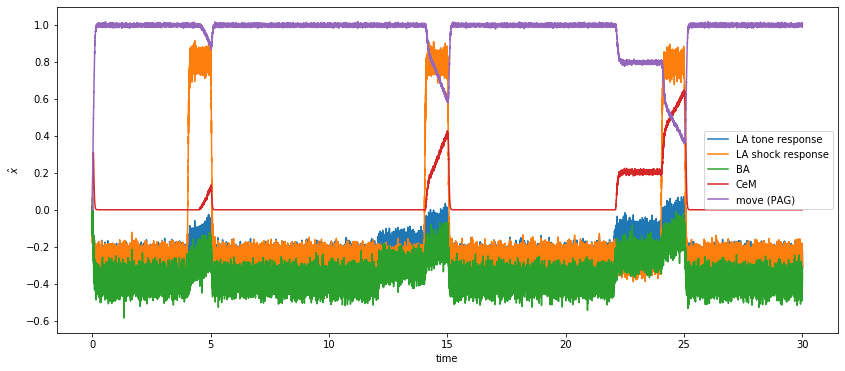

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

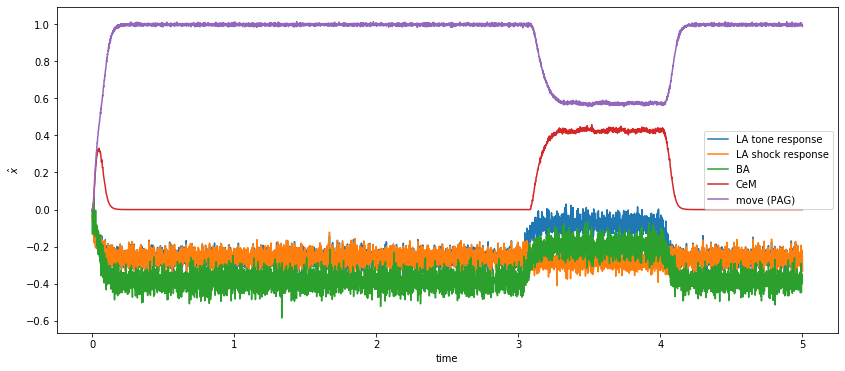

In [52]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]

data = go(t, np.zeros((200, 1)), np.zeros((200, 1)), np.zeros((400, 1)), tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_LA_CeL = data['LA_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, d_cortex_LA, d_LA_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

## DA/NE inhibition of BLA_GABA facilitates fear conditioning

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

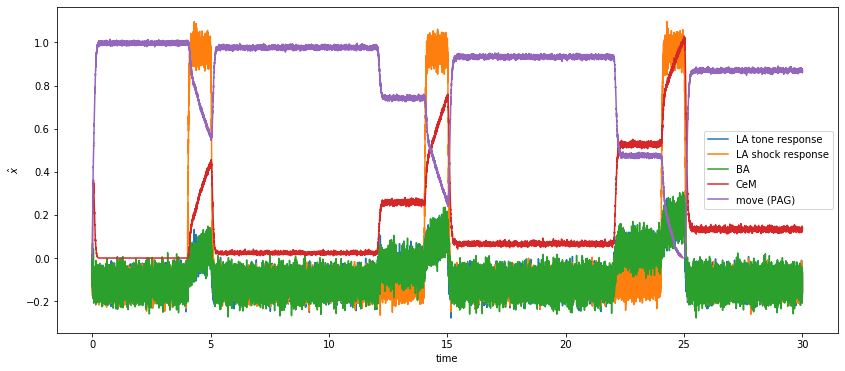

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

<IPython.core.display.Javascript object>

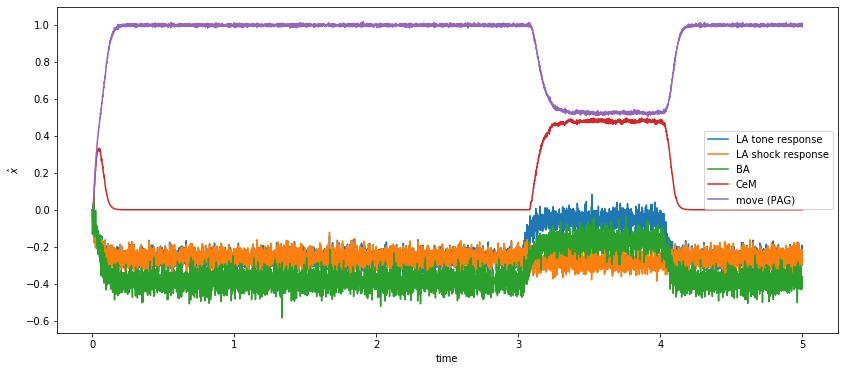

In [53]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
BLA_GABA_func = lambda t: 0

data = go(t, np.zeros((200, 1)), np.zeros((200, 1)), np.zeros((400, 1)), tone_func, shock_func, BLA_GABA_func=BLA_GABA_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_LA_CeL = data['LA_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, d_cortex_LA, d_LA_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

## seratonin excitation of BLA_GABA (or muscimol application) inhibits fear conditioning

In [ ]:
t = 30
dt = 0.001
tones, shocks = make_US_CS_arrays(pairings=int(t/10), seed=0)
tone_func = lambda t: tones[int(t/dt)]
shock_func = lambda t: shocks[int(t/dt)]
BLA_GABA_func = lambda t: 0.75

data = go(t, np.zeros((200, 1)), np.zeros((200, 1)), np.zeros((400, 1)), tone_func, shock_func, BLA_GABA_func=BLA_GABA_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

d_thal_CeL = data['thal_CeL']
d_cortex_LA = data['cortex_LA']
d_LA_CeL = data['LA_CeL']
t = 5
dt = 0.001
tone_func = lambda t: 1 if 3<t<4 else 0
shock_func = lambda t: 0

data = go(t, d_thal_CeL, d_cortex_LA, d_LA_CeL, tone_func, shock_func)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(data['times'], data['LA'][:,0], label='LA tone response')
ax.plot(data['times'], data['LA'][:,1], label='LA shock response')
ax.plot(data['times'], data['BA'], label='BA')
ax.plot(data['times'], data['CeM'], label='CeM')
ax.plot(data['times'], data['PAG'], label='move (PAG)')
ax.set(xlabel='time', ylabel=r'$\hat{x}$')
ax.legend()
plt.show()

## BA inactivation largely reduces fear responses 